In [2]:
import os
import sys
from os import path
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils
import json
import argparse
from scipy.optimize import least_squares
import coord_helper as ch
import h5py
from skyfield.api import load, EarthSatellite, Topos
from datetime import timedelta
import importlib
import scripts.xcorr.helper as h

BDC is using numpy
BDC is using numpy


In [3]:
config_file_name = 'config_mars_2024_day2.json'
baseline_idx = 1

In [4]:
with open(f"./config/{config_file_name}", "r") as f:
    config = json.load(f)
    dir_parents = []
    coords = []
    # unpack information from the json file
    # Call get_starting_index for all antennas except reference
    for i, (ant, details) in enumerate(config["antennas"].items()):
        if (i == 0) or (i ==baseline_idx):
            coords.append(details['coordinates'])
            dir_parents.append(details["path"])
    global_start_time = config["correlation"]["start_timestamp"]
    end_t = config["correlation"]["end_timestamp"]
    c_acclen = config["correlation"]["coarse_acclen"]
    v_acclen = config["correlation"]["vis_acclen"]
    visibility_window = config["correlation"]["visibility_window"]
    T_SPECTRA = config["correlation"]["point_PFB"] / config["correlation"]["sample_rate"]

print("Antenna Paths:", dir_parents)
print("Antenna Coordinates:", coords)
print("Visibility Accumulation Length", v_acclen)
print("Coarse Accumulation Length:", c_acclen)
print(global_start_time)

Antenna Paths: ['/scratch/s/sievers/mohanagr/mars1_2024/baseband/', '/scratch/s/sievers/mohanagr/mars2_2024/baseband/']
Antenna Coordinates: [[79.41718333333333, -90.76735, 189], [79.41721666666666, -90.75885, 176]]
Visibility Accumulation Length 30000
Coarse Accumulation Length: 1000000
1721900002


In [9]:
ref_coords = coords[0]
a2_coords = coords[1]

ref_path = dir_parents[0]
a2_path = dir_parents[1]

C_T_ACCLEN = c_acclen* T_SPECTRA
V_T_ACCLEN = v_acclen* T_SPECTRA

c_nchunks = int((visibility_window)/C_T_ACCLEN)
v_nchunks = int((visibility_window)/V_T_ACCLEN)

tle_path = outils.get_tle_file(global_start_time, "/project/s/sievers/mohanagr/OCOMM_TLES")

context = [visibility_window, T_SPECTRA, v_acclen, v_nchunks, tle_path]

In [6]:
observed_data = []
info = []


#with h5py.File(f'vis_all_{global_start_time}_10hrs.h5', 'r') as f:

with h5py.File(f'vis_all_{global_start_time}_10hrs.h5', 'r') as f:
    for pulse in f:
        # Access a dataset
        print(pulse)
        p = f[f'/{pulse}'].attrs['pulse_info']
        pulse_info = [[int(p[0]), int(p[1])], int(p[2]), int(p[3]), int(p[4])]
        data = f[f'/{pulse}'][:]
        
        if pulse == '32350_1836':
            pulse_info = [[int(p[0]), int(p[1])-50], int(p[2]), int(p[3]), int(p[4]), global_start_time, tle_path]
            data = f[f'/{pulse}'][:-102]


        
        info.append(pulse_info)
        observed_data.append(data)
print(info)

#possible to-do here is to order them by start time. but might not really matter.
print(len(info))

12925_1841
13600_1849
13600_1850
14150_1836
14150_1837
14870_1836
14870_1837
17330_1836
17330_1837
18935_1841
19660_1849
19660_1850
20155_1836
20155_1837
20155_1850
20885_1836
20885_1837
2110_1836
2110_1837
26265_1836
26265_1837
26265_1850
26905_1836
26905_1837
29455_1836
29455_1837
30935_1841
30935_1846
31790_1850
32350_1836
32350_1837
32920_1836
32920_1837
32920_1838
35515_1836
35515_1837
6920_1841
8135_1836
8135_1837
[[[12925, 13380], 25338, 1841, 79705], [[13600, 13905], 33591, 1849, 79730], [[13600, 13905], 33591, 1850, 79705], [[14150, 14695], 59051, 1836, 79731], [[14150, 14695], 59051, 1837, 79731], [[14870, 15215], 57166, 1836, 79731], [[14870, 15215], 57166, 1837, 79731], [[17330, 17605], 28654, 1836, 79705], [[17330, 17605], 28654, 1837, 79730], [[18935, 19455], 25338, 1841, 103131], [[19660, 20125], 33591, 1849, 79756], [[19660, 20125], 33591, 1850, 79705], [[20155, 20695], 59051, 1836, 79730], [[20155, 20695], 59051, 1837, 79731], [[20155, 20695], 59051, 1850, 81129], [[20

In [7]:
pulse_idx = 38
print(info[pulse_idx])

[[8135, 8680], 59051, 1837, 79731]


1108


IndexError: list index out of range

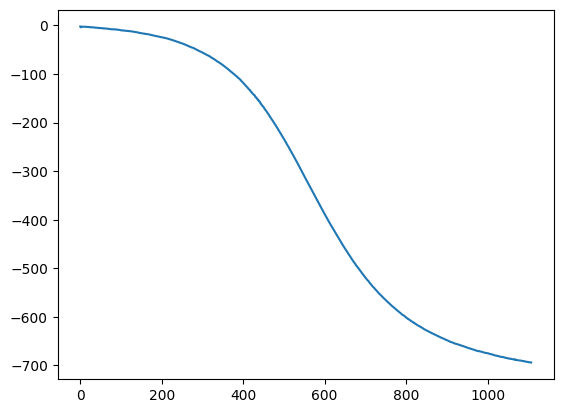

In [8]:
plt.plot(observed_data[pulse_idx], label="Observed Phase")
print(len(observed_data[pulse_idx]))
plt.plot(ch.phase_pred(a2_coords, pulse_idx, info, context), label="Unfitted Predicted Phase")
print(len(ch.phase_pred(a2_coords, pulse_idx, info, context)))
plt.xlabel("Chunks (~0.5s intervals)")
plt.ylabel("Phase (Radians)")
plt.title("Unfitted Predicted Phase")
plt.legend()

In [43]:
#super far but smooth: 34, 24, 
#has a bump: 32, 13, 20

good_pulse_idxs0 = [0, 2, 4, 7, 11, 13, 20, 24, 26, 28, 29, 30, 32, 34, 36, 38]
print(len(good_pulse_idxs0))

16


In [9]:
pulse_data0 = [observed_data[i] for i in good_pulse_idxs0]
pulse_info0 = [info[i] for i in good_pulse_idxs0]

sats = []
for i in pulse_info0:
    sats.append(i[1])

for item in set(sats):
    print(item, sats.count(item))

59051 6
57166 1
28654 3
33591 3
25338 3


In [10]:
print(info[30])

[[32350, 32715], 59051, 1837, 44658]


In [61]:
#good_pulse_idxs = 
good_pulse_idxs = [0, 2, 4, 7, 8, 11,26, 28, 29, 30, 36, 38]

In [62]:
pulse_data = [observed_data[i] for i in good_pulse_idxs]
pulse_info = [info[i] for i in good_pulse_idxs]

sats = []
for i in pulse_info:
    sats.append(i[1])

for item in set(sats):
    print(item, sats.count(item))

print(len(pulse_data))

25338 3
59051 4
28654 2
33591 3
12


In [63]:
#info is pulse_info
#observed is pulse_data

catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC


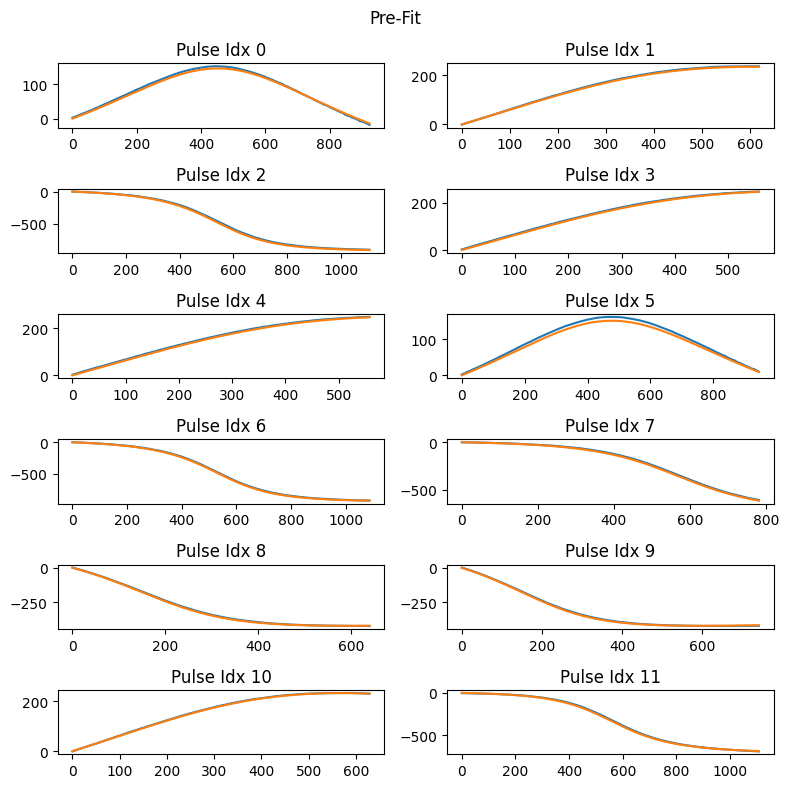

In [64]:
fig, ax = plt.subplots(int(np.ceil(len(pulse_data)/2)), 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Pre-Fit")
for pulse_idx in range(len(pulse_data)):
    predicted_data = ch.phase_pred(a2_coords, pulse_idx, pulse_info, context)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(pulse_data[pulse_idx])
    ax[pulse_idx].plot(predicted_data)
plt.tight_layout()
#fig.savefig(path.join(out_path,f"pre_fit_calib_plots_{tstart}.jpg"))
#print(path.join(out_path,f"dg_cxcorr_{tstart}_{pstart}_{pend}.jpg"))

catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC


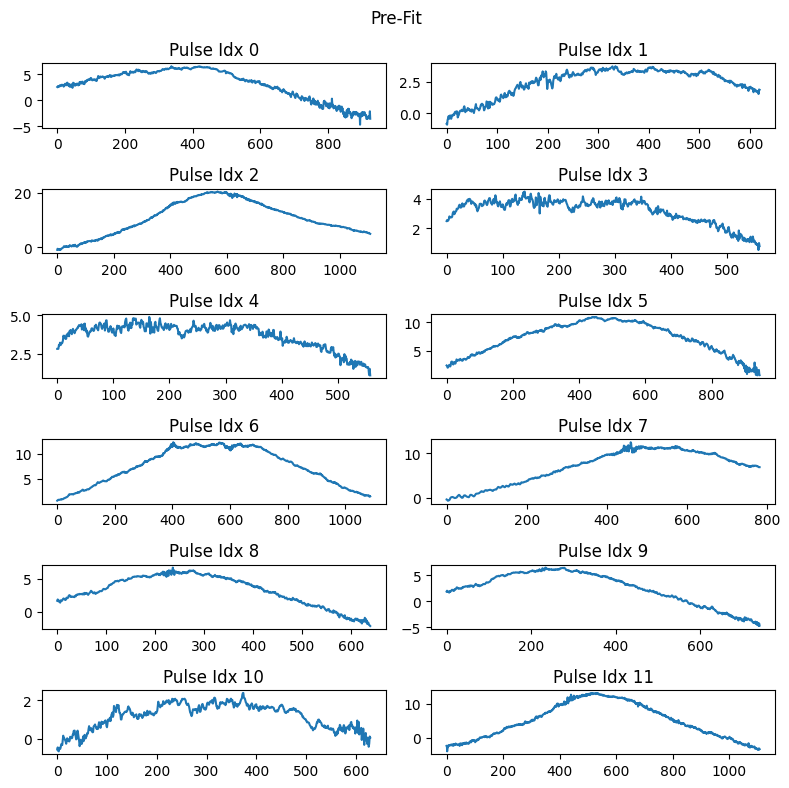

In [65]:
fig, ax = plt.subplots(int(np.ceil(len(pulse_data)/2)), 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Pre-Fit")
for pulse_idx in range(len(pulse_data)):
    predicted_data = ch.phase_pred(a2_coords, pulse_idx, pulse_info, context)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(pulse_data[pulse_idx] - predicted_data)
plt.tight_layout()

In [77]:
importlib.reload(ch)

<module 'coord_helper' from '/home/s/sievers/thomasb/albatros_analysis/scripts/orbcomm/fitting/coord_helper.py'>

In [67]:
off_1 = ch.fitting_all_with_offsets(pulse_data, a2_coords, ch.phase_pred, pulse_info, context)

catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #2

In [68]:
print(off_1[0])

[ 79.41722193 -90.75888013 182.76248769]


catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC


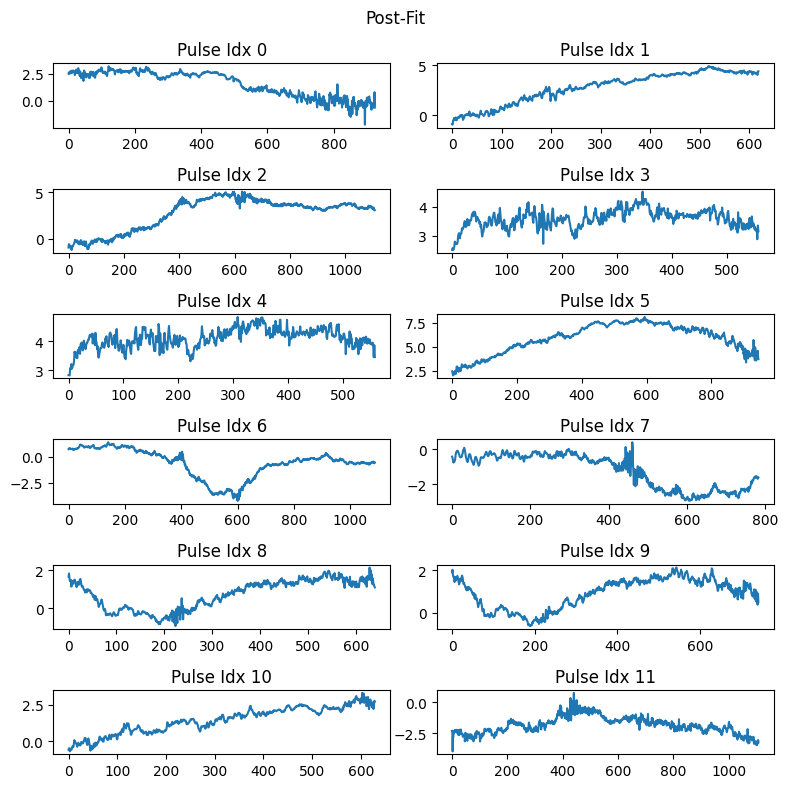

In [70]:
fig, ax = plt.subplots(int(np.ceil(len(pulse_data)/2)), 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Post-Fit")
for pulse_idx in range(len(pulse_data)):
    predicted_data = ch.phase_pred(off_1[0], pulse_idx, pulse_info, context)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(pulse_data[pulse_idx] - predicted_data)
plt.tight_layout()

In [72]:
ch.distance_calculator([ 79.41722806, -90.75887277, 182.70634794], off_1[0])

(0.6975768384326284, 0.05613974511609854)

In [ ]:
config_file_name2 = 'config_mars_2024_day1.json'

In [ ]:
with open(f"./config/{config_file_name2}", "r") as f:
    config = json.load(f)
    dir_parents = []
    coords = []
    # unpack information from the json file
    # Call get_starting_index for all antennas except reference
    for i, (ant, details) in enumerate(config["antennas"].items()):
        if (i == 0) or (i ==baseline_idx):
            coords.append(details['coordinates'])
            dir_parents.append(details["path"])
    global_start_time2 = config["correlation"]["start_timestamp"]
    end_t = config["correlation"]["end_timestamp"]
    c_acclen = config["correlation"]["coarse_acclen"]
    v_acclen = config["correlation"]["vis_acclen"]
    visibility_window = config["correlation"]["visibility_window"]
    T_SPECTRA = config["correlation"]["point_PFB"] / config["correlation"]["sample_rate"]

print("Antenna Paths:", dir_parents)
print("Antenna Coordinates:", coords)
print("Visibility Accumulation Length", v_acclen)
print("Coarse Accumulation Length:", c_acclen)
print(global_start_time2)

In [ ]:
ref_coords = coords[0]
a2_coords = coords[1]

ref_path2 = dir_parents2[0]
a2_path2 = dir_parents2[1]

C_T_ACCLEN = c_acclen* T_SPECTRA
V_T_ACCLEN = v_acclen* T_SPECTRA

c_nchunks = int((visibility_window)/C_T_ACCLEN)
v_nchunks = int((visibility_window)/V_T_ACCLEN)

tle_path2 = outils.get_tle_file(global_start_time2, "/project/s/sievers/mohanagr/OCOMM_TLES")

context2 = [global_start_time2, visibility_window, [T_SPECTRA, v_acclen, v_nchunks], ref_coords, tle_path]

In [79]:
print(solid_1[0])

[np.float64(79.41721792907687), np.float64(-90.75887018105128), np.float64(182.7624876851161)]


In [121]:

# -- Load TLE data --

satellites = load.tle_file(f'{tle_path}')
by_name = {sat.name: sat for sat in satellites}


# -- Observer location --
lat, lon, elevation_m = 34.0, -118.0, 100  # Example: Los Angeles
observer = Topos(latitude_degrees=lat, longitude_degrees=lon, elevation_m=elevation_m)

# -- Observation time window --
start_dt = t0.utc_datetime()
datetimes = [start_dt + timedelta(seconds=i) for i in range(0, 3600, 10)]
t_array = ts.utc(datetimes)

# -- Compute azimuth and elevation --
azimuths = []
elevations = []

for t in t_array:
    difference = satellite - observer
    topocentric = difference.at(t)
    alt, az, _ = topocentric.altaz()
    if alt.degrees > 0:  # Only include satellite when it's above horizon
        azimuths.append(np.radians(az.degrees))
        elevations.append(90 - alt.degrees)  # Invert for polar plot

# -- Make the polar plot --
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

ax.plot(azimuths, elevations, marker='o', markersize=2, linewidth=1.5)
ax.set_theta_zero_location('N')     # 0° azimuth (north) at the top
ax.set_theta_direction(-1)          # Clockwise azimuth

ax.set_rlim(0, 90)                  # 0° (zenith) in center, 90° (horizon) at edge
ax.set_rlabel_position(135)        # Put radial labels in SE quadrant
ax.set_title(f"Sky Track of {tle_lines[0]} Overhead Pass", va='bottom')
plt.show()


dict_keys([None])


KeyError: '59051'